## Exploration of the date features ##

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train = pd.read_csv('~/data/red_hat/act_train.csv', parse_dates=['date'])
test = pd.read_csv('~/data/red_hat/act_test.csv', parse_dates=['date'])
ppl = pd.read_csv('~/data/red_hat/people.csv', parse_dates=['date'])

df_train = pd.merge(train, ppl, on='people_id')
df_test = pd.merge(test, ppl, on='people_id')
del train, test, ppl

First just so we know what we're dealing with, let's take a look at the range of the two date variables

In [5]:
for d in ['date_x', 'date_y']:
    print('Start of ' + d + ': ' + str(df_train[d].min().date()))
    print('  End of ' + d + ': ' + str(df_train[d].max().date()))
    print('Range of ' + d + ': ' + str(df_train[d].max() - df_train[d].min()) + '\n')

Start of date_x: 2022-07-17
  End of date_x: 2023-08-31
Range of date_x: 410 days 00:00:00

Start of date_y: 2020-05-18
  End of date_y: 2023-08-31
Range of date_y: 1200 days 00:00:00



So we can see that all the dates are a few years in the future, all the way until 2023! Although we now though that [this is because the data was anonymised](https://www.kaggle.com/c/predicting-red-hat-business-value/forums/t/22642/data-question/130058#post130058), so we can essentially treat these as if they were the last few years instead.

We can also see that date_x is on the order of 1 year, while date_y is 3 times longer, even though they both end on the same day (the date before they stopped collecting the dataset perhaps?)

----

We'll go on more into looking at how the two features relate to each other later, but first let's look at the structure of the features separately.

### Feature structure ###

Here I'm grouping the activities by date, and then for each date working out the number of activities that happened on that day as well as the probability of class 1 on that day.

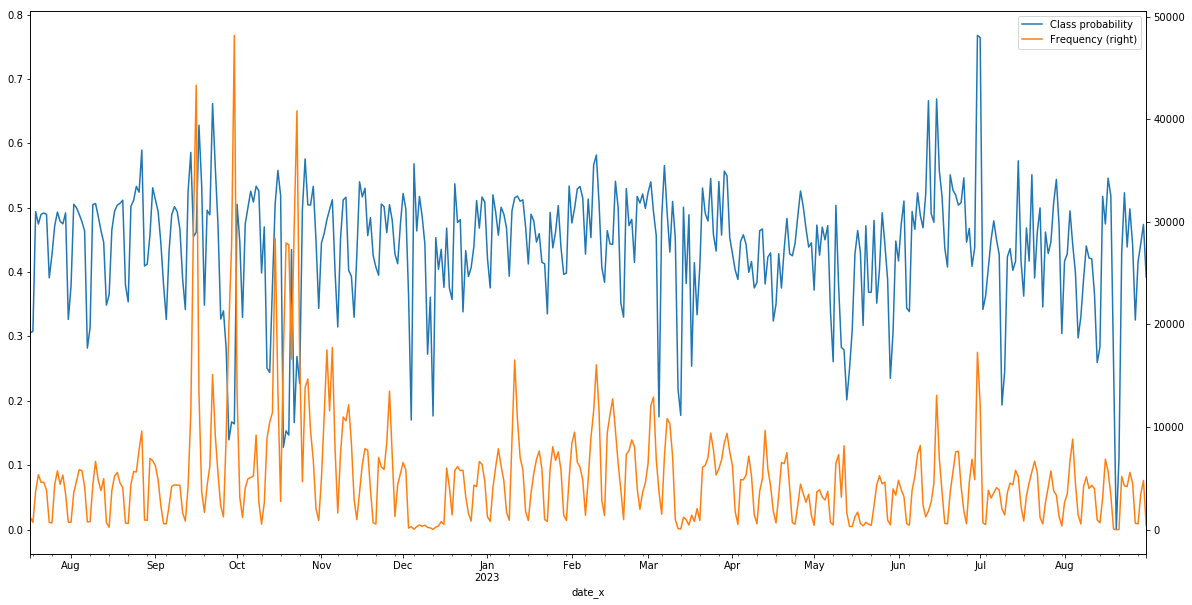

In [6]:
date_x = pd.DataFrame()
date_x['Class probability'] = df_train.groupby('date_x')['outcome'].mean()
date_x['Frequency'] = df_train.groupby('date_x')['outcome'].size()
date_x.plot(secondary_y='Frequency', figsize=(20, 10))

This plot shows some very interesting findings. There appears to be a very apparent weekly pattern, where on weekends there are much less events, as well as the probability of a event being a '1' class being much lower. 

We can see that during the week the classes are pretty balanced at ~0.5 while on weekends they drop to 0.4-0.3 (this could be very useful information). 

We can also see some very big peaks in number of activities around the September-October time frame, which we will look into later in the EDA. But first, let's do the same with the other date feature, date_y!

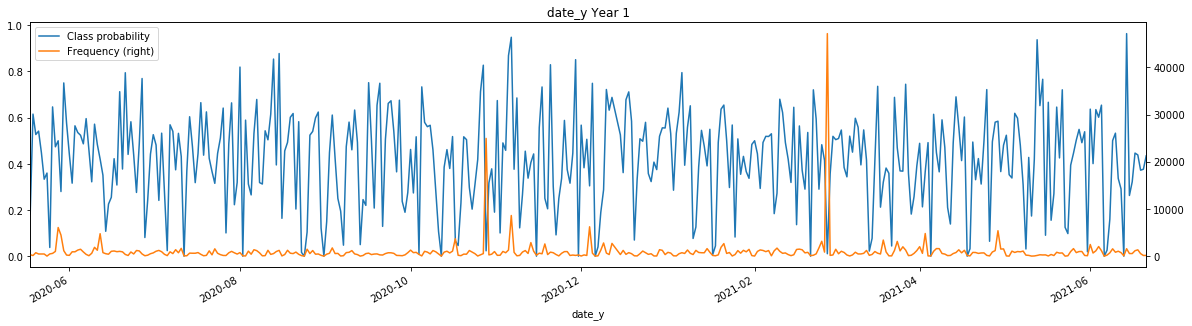

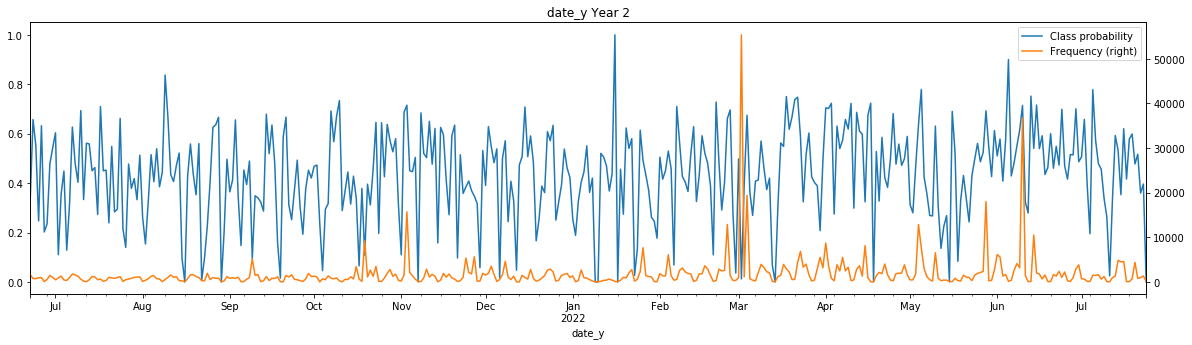

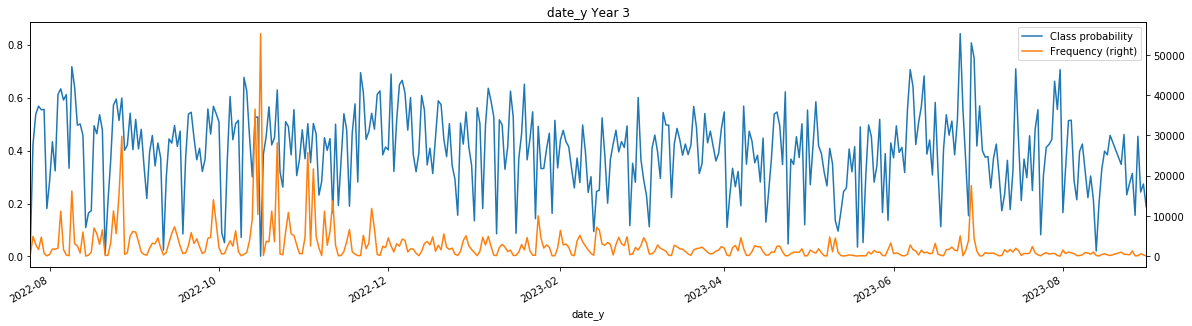

In [7]:
date_y = pd.DataFrame()
date_y['Class probability'] = df_train.groupby('date_y')['outcome'].mean()
date_y['Frequency'] = df_train.groupby('date_y')['outcome'].size()
# We need to split it into multiple graphs since the time-scale is too long to show well on one graph
i = int(len(date_y) / 3)
date_y[:i].plot(secondary_y='Frequency', figsize=(20, 5), title='date_y Year 1')
date_y[i:2*i].plot(secondary_y='Frequency', figsize=(20, 5), title='date_y Year 2')
date_y[2*i:].plot(secondary_y='Frequency', figsize=(20, 5), title='date_y Year 3')

There also appears to be a weekly structure to the date_y variable, although it isn't as cleanly visible. However, the class probabilities appear to swing much lower (reaching 0.2 on a weekly basis)

We have to take these class probabilities with a grain of salt however, since we are hitting very low numbers of samples in each day with the date_y (in the hundreds).

----

### Test set ###

However, all of this information is useless if the same pattern doesn't emerge in the test set - let's find out if this is the case!

Since we don't know the true class values, we can't check if the same class probability appears in the test set, however we can check that the distribution of samples is the same.

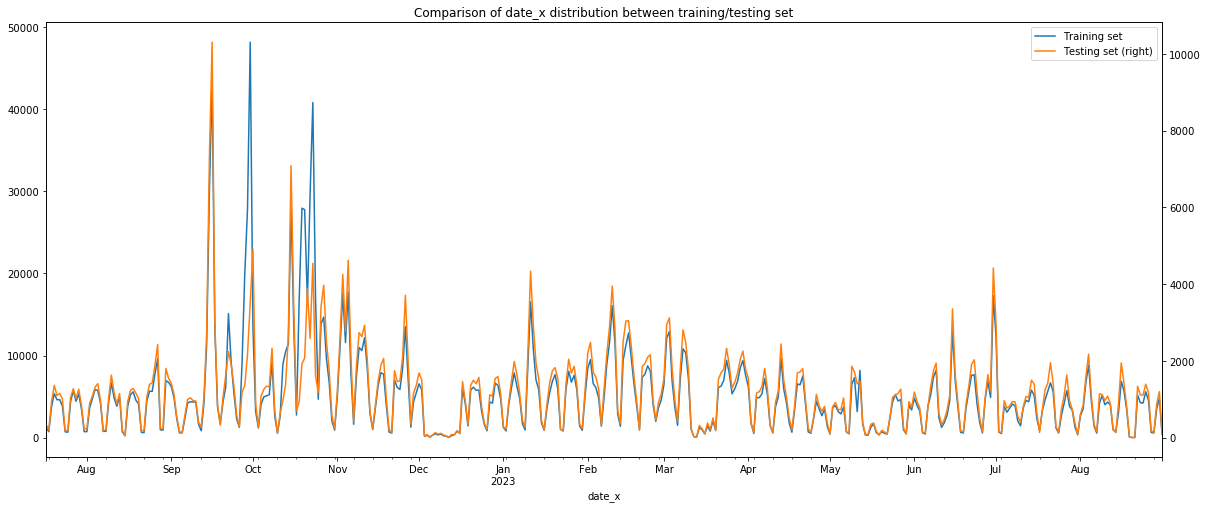

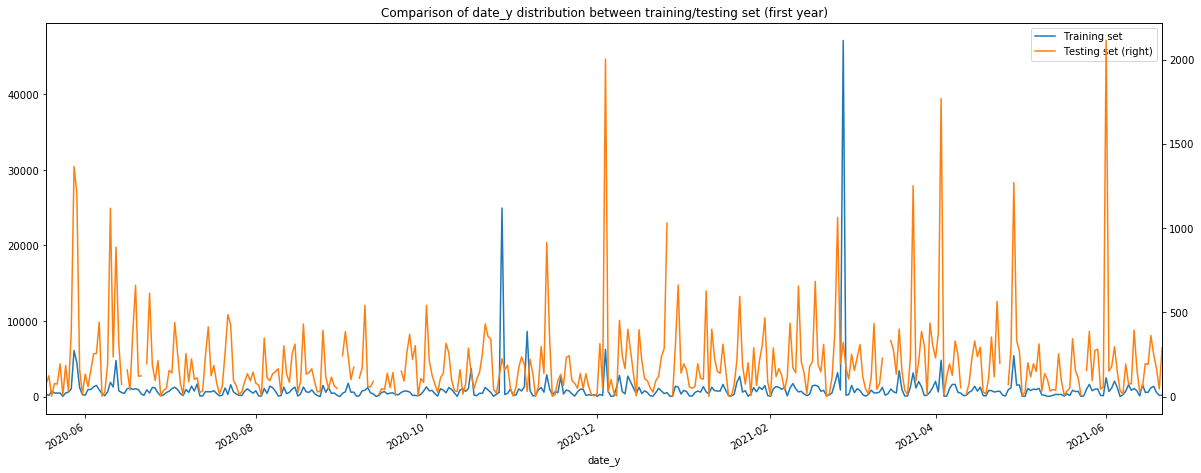

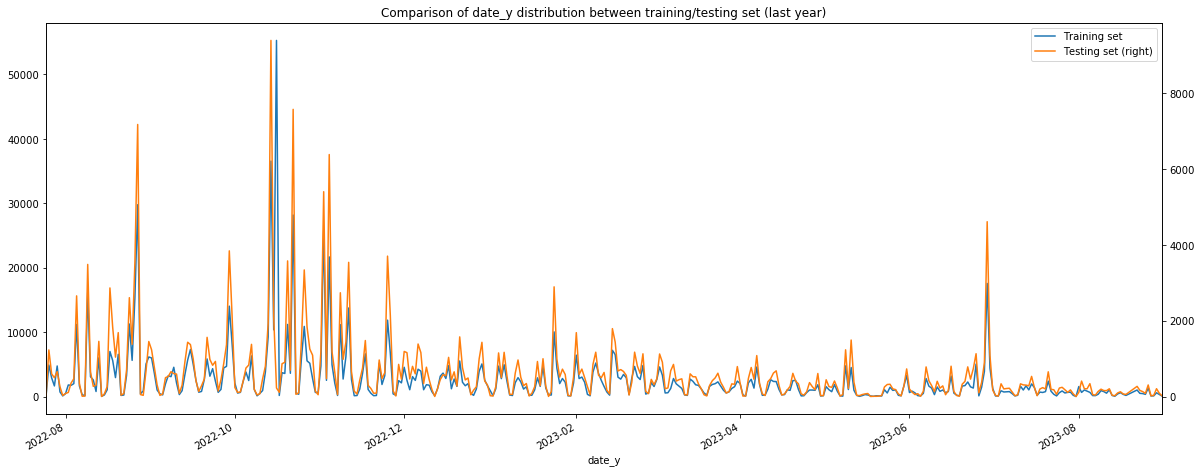

In [8]:
date_x_freq = pd.DataFrame()
date_x_freq['Training set'] = df_train.groupby('date_x')['activity_id'].count()
date_x_freq['Testing set'] = df_test.groupby('date_x')['activity_id'].count()
date_x_freq.plot(secondary_y='Testing set', figsize=(20, 8), 
                 title='Comparison of date_x distribution between training/testing set')
date_y_freq = pd.DataFrame()
date_y_freq['Training set'] = df_train.groupby('date_y')['activity_id'].count()
date_y_freq['Testing set'] = df_test.groupby('date_y')['activity_id'].count()
date_y_freq[:i].plot(secondary_y='Testing set', figsize=(20, 8), 
                 title='Comparison of date_y distribution between training/testing set (first year)')
date_y_freq[2*i:].plot(secondary_y='Testing set', figsize=(20, 8), 
                 title='Comparison of date_y distribution between training/testing set (last year)')

In [9]:
print('Correlation of date_x distribution in training/testing sets: ' + str(np.corrcoef(date_x_freq.T)[0,1]))
print('Correlation of date_y distribution in training/testing sets: ' + str(np.corrcoef(date_y_freq.fillna(0).T)[0,1]))

Correlation of date_x distribution in training/testing sets: 0.853430807691
Correlation of date_y distribution in training/testing sets: 0.709589035055


This gives us some interesting results. For date_x, we observe in the graph (and also in the high correlation value) that the training and testing sets have a very similar structure - this provides strong evidence that the training and testing sets are split based on people, and not based on time or some other unknown factor. Once again, we also observe the peaks (outliers?) in the September/October region.

However, the date_y is less clear cut. There is a low correlation between the two sets, although there is definitely some relationship that we can see visually. There appears to be very many spikes in the test set in the first year (what could this mean?) That being said, in the last year of date_y the relationship between the two sets is much more apparent. Let's try looking at the correlations over the years.

In [10]:
print('date_y correlation in year 1: ' + str(np.corrcoef(date_y_freq[:i].fillna(0).T)[0,1]))
print('date_y correlation in year 2: ' + str(np.corrcoef(date_y_freq[i:2*i].fillna(0).T)[0,1]))
print('date_y correlation in year 3: ' + str(np.corrcoef(date_y_freq[2*i:].fillna(0).T)[0,1]))

date_y correlation in year 1: 0.237056344324
date_y correlation in year 2: 0.682344221229
date_y correlation in year 3: 0.807207224857


Wow, that is definitely a huge improvement over time! Something about the structure of the first year of date_y doesn't match up, so we should keep that in mind (If anyone has any theories I would love to hear them).

----
### Probability features ###

To wrap up the first part of this EDA, I'm going to try turning the date class probabilities into features that we could use in our model, and then we can take a look at the AUCs that they give.

In [11]:
from sklearn.metrics import roc_auc_score
features = pd.DataFrame()
features['date_x_prob'] = df_train.groupby('date_x')['outcome'].transform('mean')
features['date_y_prob'] = df_train.groupby('date_y')['outcome'].transform('mean')
features['date_x_count'] = df_train.groupby('date_x')['outcome'].transform('count')
features['date_y_count'] = df_train.groupby('date_y')['outcome'].transform('count')
_=[print(f.ljust(12) + ' AUC: ' + str(round(roc_auc_score(df_train['outcome'], features[f]), 6))) for f in features.columns]

date_x_prob  AUC: 0.626182
date_y_prob  AUC: 0.720296
date_x_count AUC: 0.465697
date_y_count AUC: 0.475916


It looks like the date probability features have very high predictive power! I think we might be onto something here.

Anyway, that's all I've got for now. I'll be back with more graphs and text soon, in the meantime if anyone has any theories or questions feel free to ask/discuss in the comments.

**Make sure to upvote if this was useful (and motivate me to make more!)**